# Lab 06-1: Optimizers for Deep Neural Networks
## Exercise: Predicting MNIST Digits
### For this exercise, prepare Lab 05-3 to copy your previous implementations.

### Prepare Mini-MNIST Dataset

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

digits = load_digits()

# digits.data from sklearn contains 1797 images of 8x8 pixels
# Each image has a hand-written digit
digits_df = digits.images.reshape((len(digits.target), -1))
digits_tf = digits.target

# Splitting dataframe into train & test
X_train_org, X_test_org, y_train_num, y_test = train_test_split(digits_df, digits_tf, test_size= 0.20, random_state= 101)

# Digits data has range of [0,16], which often lead too big exponential values
# so make them normal distribution of [0,1] with the sklearn package, or you can just divide them by 16
sc = StandardScaler()
X_train = sc.fit_transform(X_train_org)
X_test = sc.transform(X_test_org)

n_classes = 10

# Transform Nx1 Y vector into Nx10 answer vector, so that we can perform one-to-all classification
y_train = np.zeros((y_train_num.shape[0],10))
for i in range(n_classes):
    y_train[:,i] = (y_train_num == i)

Define Utility Functions

In [2]:
def sigmoid(x):
    # Numerically stable with large exponentials
    x = np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))
    return x

def softmax(x):
    # Numerically stable with large exponentials
    x = x - np.max(x, axis=-1, keepdims=True)
    x = np.exp(x)
    xs = np.sum(x, axis=-1, keepdims=True)
    return x / xs

(1797, 64)
(1437, 64)
(1437, 10)
[ 0.  0.  0.  9. 16.  6.  0.  0.  0.  0.  4. 15.  6. 15.  0.  0.  0.  0.
  8. 11.  9. 11.  0.  0.  0.  0.  8. 16. 14.  2.  0.  0.  0.  0. 11. 16.
 13.  0.  0.  0.  0.  6. 14.  2. 12.  9.  0.  0.  0.  5. 16. 11.  5. 13.
  4.  0.  0.  0.  3.  8. 13. 16.  9.  0.]


<Figure size 432x288 with 0 Axes>

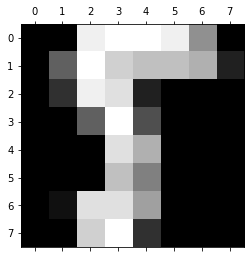

The number is 5


In [3]:
print(digits_df.shape)
print(X_train.shape)
print(y_train.shape)
print(X_train_org[0])

idx = np.random.randint(X_train.shape[0])
dimage = X_train_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()
print('The number is', y_train_num[idx])


### Simple DNN for Digit Classification

Define Model Class (<b>From the previous exercise 05-3</b>)

In [4]:
class myNeuralLayer:
    def __init__(self, n_out, n_in):
        self.wegt = np.zeros((n_out, n_in))
        self.bias = np.zeros((n_out))

    def forward(self, x):       # (b, i)
        ### START CODE HERE ###

        x_lin = x @ self.wegt.T + self.bias            # Linear Prediction
        
        ### END CODE HERE ###
        return x_lin

    def backward(self, x, x_in):  # x = dJ/dz (b, c)
        ### START CODE HERE ###
        
        dw = x.T @ x_in / x.shape[0]               # Gradients for weights
        db = np.mean(x, axis=0)               # Gradients for biases
        wdJdz = x @ self.wegt            # Propagation for lower layer
        
        ### END CODE HERE ###
        return dw, db, wdJdz


Define Backpropagation of Activation Functions (<b>From the previous exercise 05-3</b>)

In [5]:
def dJdz_sigmoid(wdJdz_upper, az):
    ### START CODE HERE ###

    dJdz = wdJdz_upper * az * (1 - az)            # backpropagation through activation function

    ### END CODE HERE ###
    return dJdz

def dJdz_softmax(y_hat, y):
    ### START CODE HERE ###

    dJdz = y_hat - y            # backpropagation through activation function
    
    ### END CODE HERE ###
    return dJdz

Define Training Functions (<b>From the previous exercise 05-3</b>)

In [6]:
def my_forward(l1, l2, l3, X_in):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward

    ### END CODE HERE ###
    return a_1, a_2, a_3

def my_backward(l1, l2, l3, a_1, a_2, a_3, X_in, y_true):
    ### START CODE HERE ###

    dw_3, db_3, wdJdz_3 = l3.backward(dJdz_softmax(a_3, y_true), a_2)    # go through 3rd stage backward
    dw_2, db_2, wdJdz_2 = l2.backward(dJdz_sigmoid(wdJdz_3, a_2), a_1)    # go through 2nd stage backward
    dw_1, db_1, _       = l1.backward(dJdz_sigmoid(wdJdz_2, a_1), X_in)    # go through 1st stage backward

    ### END CODE HERE ###

    d_1 = [dw_1, db_1]
    d_2 = [dw_2, db_2]
    d_3 = [dw_3, db_3]
    
    return d_1, d_2, d_3

def my_loss(l1, l2, l3, X_in, y_true):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                    # third stage forward
    loss = -np.mean(y_true * l3.forward(a_2) - np.log(1 + np.exp(l3.forward(a_2))))
                                                     # calculate loss

    ### END CODE HERE ###
    return loss
    
def my_predict(l1, l2, l3, X_in):
    ### START CODE HERE ###

    a_1 = sigmoid(l1.forward(X_in))                    # first stage forward
    a_2 = sigmoid(l2.forward(a_1))                    # second stage forward
    a_3 = softmax(l3.forward(a_2))                   # third stage forward
    pred = np.argmax(a_3, axis=1)                   # make prediction

    ### END CODE HERE ###
    return pred

Create a NN model and check the matrix dimensions

In [7]:
n_inputs  = 64
n_hidden1 = 80
n_hidden2 = 70
n_classes = 10

l1 = myNeuralLayer(n_hidden1, n_inputs)
l2 = myNeuralLayer(n_hidden2, n_hidden1)
l3 = myNeuralLayer(n_classes, n_hidden2)

print(X_train.shape, y_train.shape)
print(l1.wegt.shape, l1.bias.shape)
print(l2.wegt.shape, l2.bias.shape)
print(l3.wegt.shape, l3.bias.shape)

(1437, 64) (1437, 10)
(80, 64) (80,)
(70, 80) (70,)
(10, 70) (10,)


Weight Initialization

In [8]:
# Weights are initialized to...
l1.wegt = np.random.randn(n_hidden1, n_inputs)
l2.wegt = np.random.randn(n_hidden2, n_hidden1)
l3.wegt = np.random.randn(n_classes, n_hidden2)

Define a Function for Splitting Dataset into mini-Batches

In [9]:
def create_mini_batches(X, y, batch_size=64):
    mini_batches = []
    n_minibatches = (X.shape[0] // batch_size)
    n_variables = X.shape[1]
    ### START CODE HERE ###

    data = np.hstack((X,y))                  # concatenate X and y with np.hstack
    np.random.shuffle(data)      # then shuffle it
    
    for i in range(n_minibatches):
        mini_batch = data[i*batch_size:(i+1)*batch_size]        # get a slice of mini-batch
        X_mini, y_mini = mini_batch[:,:n_variables], mini_batch[:,n_variables:]    # split mini-batch into X & y
        mini_batches.append((X_mini, y_mini))
    
    if data.shape[0] % batch_size != 0:
        mini_batch = data[n_minibatches*batch_size:]        # process the remaining data
        X_mini, y_mini = mini_batch[:,:n_variables], mini_batch[:,n_variables:]    # split mini-batch into X & y
        mini_batches.append((X_mini, y_mini))

    ### END CODE HERE ###
    return mini_batches

In [10]:
np.random.seed(1)

a = np.arange(20).reshape(10,2)
b = -np.arange(10,20).reshape(10,1)

c = create_mini_batches(a, b, 4)
for mini_X, mini_y in c:
    print(mini_X)
    print(mini_y, '\n')


[[ 4  5]
 [18 19]
 [12 13]
 [ 8  9]]
[[-12]
 [-19]
 [-16]
 [-14]] 

[[ 0  1]
 [ 6  7]
 [ 2  3]
 [14 15]]
[[-10]
 [-13]
 [-11]
 [-17]] 

[[16 17]
 [10 11]]
[[-18]
 [-15]] 



expected outpu:
```
[[ 4  5]          [[ 0  1]           [[16 17] 
 [18 19]           [ 6  7]            [10 11]] 
 [12 13]           [ 2  3]           [[-18] 
 [ 8  9]]          [14 15]]           [-15]]  
[[-12]            [[-10]             
 [-19]             [-13]             
 [-16]             [-11]             
 [-14]]            [-17]]              
```

## Define Various Optimizers

Stochastic Gradient $$ g_t = \nabla J(W_t,x^{(i)},y^{(i)}), \;\text{for mini-batch}\; (i) \to (i:i+n) $$

SGD with momentum $$ \Delta W(t) = \gamma \Delta W (t-1) + \alpha \cdot g_t $$
AdaGrad $$ \Delta W(t) = {\eta {1 \over \sqrt{\delta_t + \epsilon}}} \odot g_t, \;\text{where}\; \delta_t = \delta_{t-1} + g_t^2 $$
RMSProp $$ \Delta W(t) = {\eta {1 \over \sqrt{\delta_t + \epsilon}}} \odot g_t, \;\text{where}\; \delta_t = \beta \delta_{t-1} + (1-\beta) g_t^2 $$
Adam $$ \Delta W(t) = {\eta {\hat{m}_t \over \sqrt{\hat{v}_t} + \epsilon}} \odot g_t, \;\text{where}\; \hat{m}_t = {m_t \over {1 - \beta_1^t}}, \; \hat{v}_t = {v_t \over {1 - \beta_2^t}}, $$
$$ \text{and}\; m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, \; v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $$


In this experiment mini-batch gradient is used for all optimization methods unless mentioned otherwise.<br>
Investigate and discuss the effect on convergence of each optimizer

In [11]:
class myOptParam:
    def __init__(self, n_out, n_in):
        # Previoud delta values for momentum optimizer
        self.W_dt = np.zeros((n_out, n_in))
        self.B_dt = np.zeros(n_out)
        # Variables for other optimizers
        self.W_mt = np.zeros((n_out, n_in))
        self.B_mt = np.zeros(n_out)
        self.W_vt = np.zeros((n_out, n_in))
        self.B_vt = np.zeros(n_out)

def my_optimizer(lyr, opt, W_grad, B_grad, solver='sgd', learning_rate=0.01, iter=1):
    epsilon = 1e-8  # arbitrary small number
    alpha = eta = learning_rate
    if iter==0:
        print('iteration should start from 1.')

    # optimizer routines
    if  solver=='sgd':
        W_dlt = alpha * W_grad
        B_dlt = alpha * B_grad
    elif solver=='momentum':
        gamma = 0.9               # default setting
        ### START CODE HERE ###
        
        W_dlt = gamma * opt.W_dt + alpha * W_grad              # momentum for previous delta
        B_dlt = gamma * opt.B_dt + alpha * B_grad              # same goes for bias
        opt.W_dt = W_dlt           # keep data for later use
        opt.B_dt = B_dlt           # for bias, too

        ### END CODE HERE ###
    elif solver=='adagrad':
        ### START CODE HERE ###

        opt.W_vt = opt.W_vt + W_grad**2           # accumulate delta square (2nd momentum)
        opt.B_vt = opt.B_vt + B_grad**2           # accumulater for bias term
        W_dlt = eta / np.sqrt(epsilon + opt.W_vt) * W_grad              # calculate new delta for weight
        B_dlt = eta / np.sqrt(epsilon + opt.B_vt) * B_grad              # and for bias

        ### END CODE HERE ###
    elif solver=='rmsprop':
        beta2 = 0.9               # default setting
        ### START CODE HERE ###

        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * W_grad**2           # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * B_grad**2           # also doging samething for bias
        W_dlt = eta / np.sqrt(epsilon + opt.W_vt) * W_grad              # calculate new delta for weight
        B_dlt = eta / np.sqrt(epsilon + opt.B_vt) * B_grad              # and for bias
        
        ### END CODE HERE ###
    elif solver=='adam':
        beta1, beta2 = 0.9, 0.99  # default setting
        ### START CODE HERE ###

        opt.W_mt = beta1 * opt.W_mt + (1 - beta1) * W_grad           # blending with first momentum
        opt.B_mt = beta1 * opt.B_mt + (1 - beta1) * B_grad           # first momentum for bias
        opt.W_vt = beta2 * opt.W_vt + (1 - beta2) * W_grad**2           # blending with second momentum
        opt.B_vt = beta2 * opt.B_vt + (1 - beta2) * B_grad**2           # second momentum for bias
        W_mc = opt.W_mt / (1 - beta1**iter)               # bias correction of first momentum for weight
        B_mc = opt.B_mt / (1 - beta1**iter)               # and for bias term
        W_vc = opt.W_vt / (1 - beta2**iter)               # bias correction of second momentum for weight
        B_vc = opt.B_vt / (1 - beta2**iter)               # and for bias term
        W_dlt = eta / (np.sqrt(W_vc) + epsilon) * W_mc              # calculate new delat for weight
        B_dlt = eta / (np.sqrt(B_vc) + epsilon) * B_mc              # and for bias
        
        ### END CODE HERE ###
    else:  
        print('optimizer error')

    # Adjust weight
    lyr.wegt = lyr.wegt - W_dlt
    lyr.bias = lyr.bias - B_dlt

    return

Optimizer Test

In [12]:
np.random.seed(1)

lyr = myNeuralLayer(2,3)
opt = myOptParam(2,3)

lyr.wegt = np.random.randn(2,3)
lyr.bias = np.random.randn(2)
opt.W_dt = np.random.randn(2,3)
opt.B_dt = np.random.randn(2)
opt.W_mt = np.random.randn(2,3)
opt.B_mt = np.random.randn(2)
opt.W_vt = np.abs(np.random.randn(2,3))
opt.B_vt = np.abs(np.random.randn(2))

W_grad = np.random.randn(2,3)
B_grad = np.random.randn(2)

# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
my_optimizer(lyr, opt, W_grad, B_grad, 'adam', 10, 3)
print(lyr.wegt[0], lyr.bias[0])


[ 3.12812265  6.11310547 -0.00659625] -5.620045550802262


**Expected Outputs**

For SGD:
```
[8.49607236 7.8403     6.18428956] -14.853210006882223
```
For Momentum:
```
[8.20893718 8.06473334 4.86839241] -15.873602504984119
```
Fpr Adagrad:
```
[7.48870748 6.53638606 8.33582571] -7.1956640822563065
```
For RMSProp:
```
[ 9.04298939  9.58705745 16.48540342] -15.770618828227912
```
For Adam:
```
[ 3.12812265  6.11310547 -0.00659625] -5.620045550802262
```

Create Optimizer Parameters

In [13]:
o1 = myOptParam(n_hidden1, n_inputs)
o2 = myOptParam(n_hidden2, n_hidden1)
o3 = myOptParam(n_classes, n_hidden2)

Training Simple Neural Network Model (3 layer model)

In [14]:
# optimizer settings are: 'sgd', 'momentum', 'adagrad', 'rmsprop', 'adam'
# alpha is learning rate
optimizer ='adam'
alpha = 0.01
n_epochs = 1000

for epoch in range(n_epochs):

    batches = create_mini_batches(X_train, y_train, batch_size=64)
    for one_batch in batches:
        X_mini, y_mini = one_batch
        batch_len = X_mini.shape[0]  # last batch might have different length

        # Forward Path
        a_1, a_2, a_3 = my_forward(l1, l2, l3, X_mini)
        
        # Backward Path
        d_1, d_2, d_3 = my_backward(l1, l2, l3, a_1, a_2, a_3, X_mini, y_mini)

        dw_1, db_1 = d_1
        dw_2, db_2 = d_2
        dw_3, db_3 = d_3
        
        # Update weights and biases
        my_optimizer(l1, o1, dw_1, db_1, solver=optimizer, learning_rate=alpha, iter=epoch+1)
        my_optimizer(l2, o2, dw_2, db_2, solver=optimizer, learning_rate=alpha, iter=epoch+1)
        my_optimizer(l3, o3, dw_3, db_3, solver=optimizer, learning_rate=alpha, iter=epoch+1)

    if ((epoch+1)%100==0):
        loss_J = my_loss(l1, l2, l3, X_train, y_train)
        print('Epoch: %4d,  loss: %10.8f' % (epoch+1, loss_J))

12.74694836637254
Epoch:  100,  loss: 1.27469484
10.936657729221356
Epoch:  200,  loss: 1.09366577
10.97877375813984
Epoch:  300,  loss: 1.09787738
11.00203858759724
Epoch:  400,  loss: 1.10020386
11.019420327705722
Epoch:  500,  loss: 1.10194203
11.030209457107729
Epoch:  600,  loss: 1.10302095
11.040031988667803
Epoch:  700,  loss: 1.10400320
11.048016246015525
Epoch:  800,  loss: 1.10480162
11.054900672086465
Epoch:  900,  loss: 1.10549007
11.061748381969052
Epoch: 1000,  loss: 1.10617484


Evaluate Model Performance

In [15]:
from sklearn.metrics import accuracy_score

y_pred = my_predict(l1, l2, l3, X_test)

accuracy_score(y_pred, y_test)

0.9777777777777777

Neural Network from scikit-learn

In [16]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80, 70, ), activation='logistic', solver='sgd', \
                    alpha=0.01, learning_rate_init=0.01, max_iter=1000)

# Training/Fitting the Model
mlp.fit(X_train, y_train_num)

# Making Predictions
s_pred = mlp.predict(X_test)
accuracy_score(s_pred, y_test)

0.9694444444444444

### Test Model with a random sample


<Figure size 432x288 with 0 Axes>

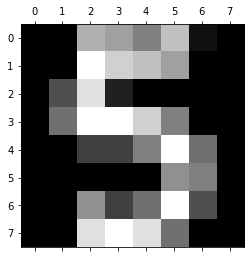

My prediction is 5
sk prediction is 5
Actual number is 5


In [17]:
idx = np.random.randint(X_test.shape[0])
dimage = X_test_org[idx].reshape((8,8))
plt.gray()
plt.matshow(dimage)
plt.show()

X_input = np.expand_dims(X_test[idx], 0)

y_pred = my_predict(l1, l2, l3, X_input)

s_pred = mlp.predict(X_input)

print('My prediction is ' + str(y_pred[0]))
print('sk prediction is ' + str(s_pred[0]))
print('Actual number is ' + str(y_test[idx]))
